# MATH60629A
# Week \#2 - Machine Learning Fundamentals - Exercises

This tutorial will focus on three important aspects of machine learning (ML), namely
1. the capacity of models, 
2. the notions of bias and variance of an estimator, as well as
3. a brief introduction to validation. 

The goal is to develop basic intuition of these concepts through a series of short exercises.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# For Colab.
!rm -rf 80-629
!git clone https://github.com/lcharlin/80-629/
import sys
sys.path += ['80-629/week2-Fundamentals/']

# We import several home functions in order to create graphics
from utilities import scatter_plot, plot_polynomial_curves, \
                      plot_optimal_curve, train_poly_and_see, MSE
%matplotlib inline

## 1.1 Model capacity

Informally, the capacity of a model can be defined as the number of functions a model can fit. Lower-capacity models can perfectly fit (i.e. obtain 0 train error) fewer functions than higher-capacity models. 

Higher-capacity models are generally more prone to **overfitting**. Overfitting occurs when the gap between the test and training error is large, or in other words, when models memorize properties of the training set that are not useful for (i.e. do not generalize to) performing predictions on a test set.

Intuitively, when two models fit the training data equally well, usually the model with less capacity will generalize better, i.e. have lower test error. Thus, as rule of thumb we prefer simpler decision rules over more complex ones. (Extra: this is a good illustration of https://en.wikipedia.org/wiki/Occam%27s_razor)

### 1.1.1 Data generation

Let's first simulate some data! In this section, every observation $y$ is generated according to the following model:

$$ y = x \cos(x / \gamma) + \epsilon$$

where $y \in \mathbb{R}$ is the output, $x \in \mathbb{R}$ are the features, $\gamma$ is the period of the cosine function and $\epsilon$ is the random noise such as $\epsilon \sim N(0, \sigma^2)$ where $\sigma$ is defined by YOU.

In [2]:
def data_simulation(sample_size, scale, period, variance):
    
    x = np.random.uniform(-scale, scale, sample_size)
    x.sort()
    noise = np.random.normal(0, variance, sample_size)
    y = x * np.cos(x / period) + noise
    
    return x, y

Whenever it is possible, it is always a good idea to visualize the data (in order to get some intuition about them). 

**Question**: Vary the parameters (*variance*, *scale* and *period*) to see how they affect the plot.

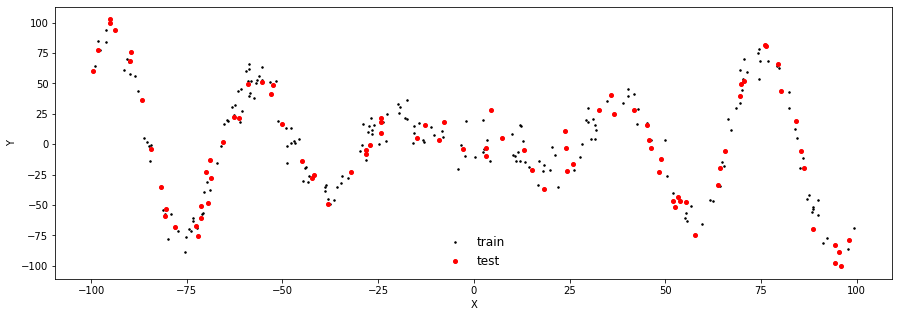

In [3]:
sample_size = 300
variance = 10   # Variance of the Gaussian noise
scale = 100   # Range
period = 6   # Simulation are based on cosine function (see data_simulation function)

x_train, y_train = data_simulation(int(.7*sample_size), scale, period, variance)
x_test, y_test = data_simulation(int(.3*sample_size), scale, period, variance)

# The scatter_plot function is in the utilities script
plt = scatter_plot(x_train, x_test, y_train, y_test)  

### 1.1.2 Getting - visual - intuition about models' capacity

As seen in class (Slide 38 for example), the higher is the capacity of the model, the better it will fit the training data set (again be cautious, fitting the training data well does not necessarily lead to good generalization). 

Here, we use [polynomial regression](https://en.wikipedia.org/wiki/Polynomial_regression) to fit the training set (don't worry, the purpose of the tutorial is not to understand polynomial regression). Note, however, that the greater is the polynomial degree, the higher is the model capacity. 

**Questions**: 
1. Observe how the fitted curve behave with respect to their polynomial degree. 
2. Would you prefer to fit the data points with polynomial regression of degree 20 or 50?
3. Which of these curves should have the best generalization error?

Polynomial degree:  0  | MSE train: 1652.9416  | MSE test: 2225.0309
Polynomial degree:  1  | MSE train: 1636.1059  | MSE test: 2140.4347
Polynomial degree:  3  | MSE train: 1544.4929  | MSE test: 1853.7897
Polynomial degree:  5  | MSE train: 1257.0468  | MSE test: 1288.1735
Polynomial degree:  10  | MSE train: 985.1257  | MSE test: 876.2953
Polynomial degree:  20  | MSE train: 91.283  | MSE test: 98.0433
Polynomial degree:  50  | MSE train: 80.8907  | MSE test: 48079.7409


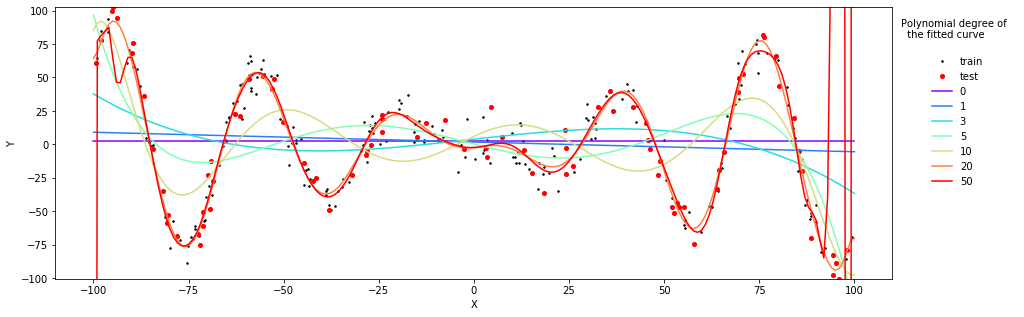

In [4]:
# Polynomial degree of the fitted curve: higher degree == higher capacity
degree = [0, 1, 3, 5, 10, 20, 50]   
plot_polynomial_curves(x_train, x_test, y_train, y_test, degree, scale)

### 1.1.3 Sample size and models' capacity

In the previous section, we discussed model capacity.

Now we study the behavior of the polynomial regressors and examine how they perform when the sample size increases (as presented on Slide 40 also Figure 5.4 of the Deep Learning book).

Specificaly, we study the behavior of the cubic polynomial regression and the optimal polynomial regression (which minimize the MSE on the test set). 

**Question**: Do the following curves behave as expected?

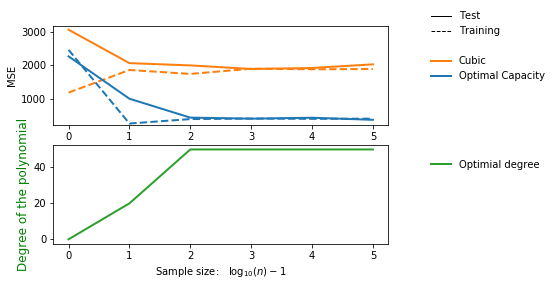

In [33]:
# Sample size of the training set that we want to study
sample_size = [10, 10**2, 10**3, 10**4, 10**5, 10**6]   
variance = 20
np.random.seed(2)

H_train, H_test, optimal_train, optimal_test, optimal_degree \
    = train_poly_and_see(sample_size, scale, period, variance, degree)

plot_optimal_curve(optimal_train, optimal_test, H_train, H_test, optimal_degree)

# 1.2 Bias and variance of estimators

We will now explore some properties of the bias and the variance of well-known estimators.

##  Linear models for regression

The polynomial curve fitting problem encountered previously is an instance of a broader class of models called linear models. More specifically, it is a linear regression task, where the goal is to predict a value of one or more continuous target variables given the values of some input variables. 

Linear models share the property of **being a linear function of the adjustable parameters** (polynomial coefficients in case of polynomial models). This simple form of linear regression models are also linear functions of the input variables. Linear models have been studied in depth by statisticians in the last century and their theory is well understood. 

In addition we hypothesize that our loss function is the squared error (i.e. ( $\sum_{i=0}^n (y_i-\hat{y}_i)^2$ ). We will study some properties of this model and loss function. 

A linear regression model fitted with a squared error is also known as an ordinary least square (OLS) regression.

First, let's simulate some data.

### 1.2.1 Data simulation

In this section, every observation $y$ is generated according to the following model:

$$ y = \bf{x}^\top \bf{w} + \epsilon$$

where $y \in \mathbb{R}$ is the output, $\bf{x}$ is the vector of covariates,  $\bf{w}$ is the vector of the associated weights and $\epsilon$ is the random noise such as $\epsilon \sim \mathcal{N}(0,1)$.

In [7]:
def data_simulation(sample_size, w_0, w_1):
    
    x = np.random.uniform(-1, 10, sample_size)
    x.sort()
    noise = np.random.normal(0, 1, sample_size)
    y = w_0 + w_1 * x + noise
    
    return x, y

Given the above generative model, we can sample the data and visualize it.

<module 'matplotlib.pyplot' from '/Users/lcharlin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

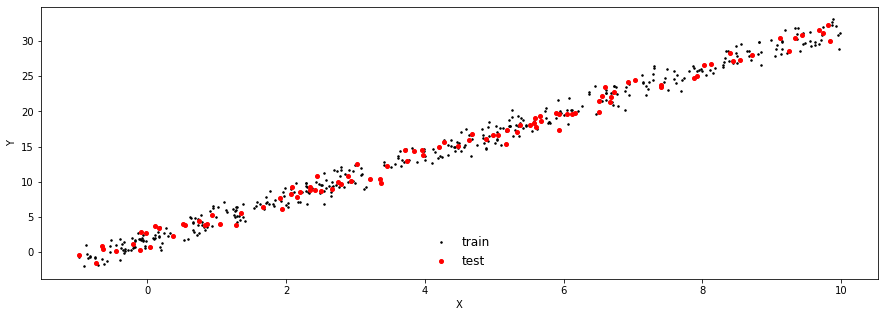

In [9]:
w_0, w_1 = 2, 3   # Fix w values
sample_size = 500   # Fix the sample size - train

X, y = data_simulation(sample_size, w_0, w_1)
X = [np.ones(len(y)), X]
X = np.asarray(X ).T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scatter_plot(X_train[:, 1], X_test [:, 1], y_train, y_test) 

### 1.2.2 The OLS estimators

**Questions**: 
1. Given the expression of the least squares estimators presented on Slide 31 of the course, complete the OLS function below to obtain the least squares estimators. As a reminder, these estimators are defined as follows:

$$ \hat{\bf{w}}^{\text{OLS}} := (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{y}$$

where $\bf{X}$ is the [design matrix](https://en.wikipedia.org/wiki/Design_matrix#:~:text=In%20statistics%2C%20a%20design%20matrix,specific%20values%20for%20that%20object.) and $\bf{y}$ is the output vector.

2. Derive the estimators associated with the previously simulated data.

*Remark*: Do not forget to calculate the intercept $\bf{w}_0$. This being said and according to the above OLS function, simply fill the first column of the design matrix with ones as suggested [here](https://en.wikipedia.org/wiki/Design_matrix#:~:text=In%20statistics%2C%20a%20design%20matrix,specific%20values%20for%20that%20object.).

**Answer**:

In [ ]:
def OLS(X, y):  
    """
    X: design matrix
    y: output vector
    
    return:  array of weights
    """
    
    A = np.linalg.inv(np.dot(X.T, X)) # (X^T * X)^-1
    B = np.dot(X.T, y) # (X^T * y)
        
    return (...)

w_ols = OLS(X_train, y_train)

**Question**: Make predictions on training and test sets and compute the associated MSE. are the results obtained those hoped for?

**Answer**:

In [ ]:
# Train set
y_hat_train = (...)

# Test set
y_hat_test = (...)

print('MSE of the train: ', MSE(y_hat_train, y_train))
print('MSE of the test:  ', MSE(y_hat_test, y_test))

#### 1.2.2.1 Bias of the OLS estimators

**Question**: Calculate the bias of the estimators.

**Answer**:

In [ ]:
bias = (...) # bias[0] should be the bias of w_0, and bias[1] should be the bias of w_1

print("Bias of w_0: ", bias[0])   # Bias of w_0
print("Bias of the w_1: ", bias[1])   # Bias of w_1

**Question**: Does it make sense?

**Answer**: Indeed! Since the OLS estimator in the contexrt of a linear regression unbiased:

\begin{align}
    \mathbb{E}[\hat{\bf{w}}^{\text{OLS}}] 
    &= \mathbb{E}[(\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{y}] \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \mathbb{E}[\bf{y}] \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \mathbb{E}[\bf{X} \bf{w} + \bf{\epsilon}] \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \{ \mathbb{E}[\bf{X} \bf{w}] + \mathbb{E}[\bf{\epsilon}] \} \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \{ \bf{X} \bf{w} + \bf{O} \} \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{X} \bf{w}  \\
    &= \bf{w}
\end{align}

**Question**: How could we reduce the observed bias of the OLS estimators?

**Answer**: 

#### 1.2.2.2 Variance of the OLS estimators (skip if you are short on time) 

The OLS estimators calculated in the last section have no fixed values and are actually [random variables](https://en.wikipedia.org/wiki/Random_variable). It follows that these estimators have variance. This variance can be estimated in several ways. In this tutorial, we propose to estimate the variance of the OLS estimators in two different ways. The first approach use [Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method#Use_in_mathematics) and the second one simply use [theoretical properties of the variance](https://en.wikipedia.org/wiki/Variance#Properties).


#### Monte Carlo methods

Don't be intimidated by the name, basic Monte Carlo methods are rather simple! As far as we are concerned, we can compute the variance of the OLS estimators in 4 easy steps.

**Question**: Complete the code below according to the commentaries.

**Answer**:

In [2]:
# The intuition behind this procedure is that we will reestimate the parameters (estimators) 
# using multiple different data sets. Each dataset is sampled from the same distribution. 
# We can then obtain the estimator variance empirically from these multiple estimators.

mc_estimates = 10000   # Fix the number of Monte Carlo estimates that you want to run
M = np.zeros((mc_estimates, 2))   # Initialize a matrix where you will store the estimators

# Step 1: Create a for loop 
for k in np.arange(mc_estimates):
    
    # Step 2: Data simulation
    x, y = (...)
    
    X = [np.ones(len(y)), x]   
    X = np.asarray(X).T
    
    # Step 3: OLS estimates
    w_ols = (...)
    M[k, :] = w_ols   # Store the estimators
     
# Step 4: Compute the variance of w_0 and w_1 (hint: np.var)
var = (...)

print("MC estimate of the variance of the w_0 estimate: ", (...))   # Variance of w_0
print("MC estimate of the variance of the w_1 estimate: ", (...))   # Variance of w_1

NameError: name 'np' is not defined

#### Analytical approach

In cases where we cannot compute the MC estimators, we can sometimes derive the analytical expression of the variance of the estimators. Indeed, the variance of the OLS is:

\begin{align}
    \text{Var}(\hat{\bf{w}}^{\text{OLS}}) 
    &= \text{Var}\left((\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{y}\right) && \text{Definition of the OLS estimators}  \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var} (\bf{y})\left((\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \right)^\top && \text{Property of the variance on matrices} \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var} (\bf{y}) \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Property of the transpose}  \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var}(\bf{X} \bf{w} + \bf{\epsilon}) \ \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Modelization of the data}\\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var}(\bf{\epsilon}) \ \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Property of the variance (only $\epsilon$ is a random variable)} \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{I} \ \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Since $\epsilon$ is iid}\\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top  \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top \\
    &= \left((\bf{X}^\top \bf{X})^{-1} \right)^\top \\
    &= (\bf{X}^\top \bf{X})^{-1} && \text{Since $\bf{X}^\top \bf{X}$ is symetric and by property of the inverse of a matrix}
\end{align}

**Question**: Compute the variance of the OLS estimators according to the above expression.

**Answer**:

In [ ]:
# Computation
var = (...)

# Interest
print("Analytical variance of the w_0 estimate: ", (...))   
print("Analytical variance of the w_1 estimate: ", (...))   

**Question**: Do the last results make sense given the MC estimates previously calculated?

**Answer**: Yes! The analytical estimates of the variance of the OLS estimators are approximately the same as those obtained by MC methods.

### 1.2.3 OLS estimators with L2-Regularization

As pointed out in Slide 45, we can add an L$_2$ regularization on the weights of the linear model defined in Section 1.1. The associated estimators are known as the [Ridge or Tikhonov estimator](https://en.wikipedia.org/wiki/Tikhonov_regularization) and are defined as

$$ \hat{w}^{\text{ridge}} := (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \bf{y}$$

where $\lambda$ is a hyperparameter (see Slides 45 and 46) which control the model's capacity. 

**Question**: Given the above expression, complete the ridge function below to obtain the ridge estimators.

**Answer**:

In [ ]:
def ridge(X, y, lambda_hp):
    
    """
    X: design matrix
    y: output vector
    lambda_hp: hyper parameter
    
    return:  array of weights
    """
    
    return (...)

**Question**: Compute the ridge estimators for different values of $\lambda$. But first, try to understand how the ridge estimator will behave according to these 3 scenarios:

1. For $\lambda = 0$. 
2. For $\lambda = 10^{10}$.
3. How the estimators generally behave according to $\lambda$? 

**Answers**:


In [ ]:
lambda_hp = 10**3
w_ridge = ridge(X_train, y_train, lambda_hp)

**Question**: Make predictions on the training and test sets. Are these predictions better than the predictions made by the OLS estimators?

**Answer**:

In [ ]:
# Train set
y_hat_train = (...)

# Test set
y_hat_test = (...)

#### 1.2.3.1 Bias of the ridge estimators

**Question**: Calculate the bias of the estimators.

**Answer**:

In [ ]:
bias = (...)

print("Bias of w_0: ", bias[0])   # Bias of w_0
print("Bias of the w_1: ", bias[1])   # Bias of w_1

**Question**: Compare the bias of the ridge estimators with those of the OLS. Does it make sense?

**Answer**: We can see that the Rigde estimators are biased. 

\begin{align}
    \mathbb{E}[\hat{\bf{w}}^{\text{ridge}}] 
    &= \mathbb{E}[(\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \bf{y}] \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \mathbb{E}[\bf{y}] \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \mathbb{E}[\bf{X} \bf{w} + \bf{\epsilon}] \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \{ \mathbb{E}[\bf{X} \bf{w}] + \mathbb{E}[\bf{\epsilon}] \} \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \{ \bf{X} \bf{w} + \bf{O} \} \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \bf{X} \bf{w}  \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} (\bf{X}^\top \bf{X} + \lambda \bf{I} - \lambda \bf{I} ) \bf{w}  \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} (\bf{X}^\top \bf{X} + \lambda \bf{I}) \bf{w} -  (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1}\lambda \bf{I} \bf{w}  \\
    &=  \bf{w} -  \lambda (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{w}.
\end{align}

Hence, the bias of the ridge estimator is:
$$ \text{Bias}(\hat{\bf{w}}^{\text{ridge}})   = -  \lambda (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{w}  $$

Note that under classical assumption, its empirical bias is always greater than the one associated to the OLS estimator.

**Remark**: One question remains: how can choose the hyper parameter value $\lambda$ of the ridge estimator? The following section will suggest an answer.

## 1.3 Validation - Getting the optimal value of hyperparameters

Validation can be used (among other techniques) in order to perform model selection and hyperparameter selection. 

The first step is to split the train set into a (smaller) train set and validation set as shown on Slide 49 of the course. 

In Python, we will mostly use the train_test_split function from the [Scikit-learn library](https://scikit-learn.org/) to perform data splitting.

In [ ]:
X_sub_train, X_validation, y_sub_train, y_validation = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=0)

We now study the performance (according to the MSE) of the ridge estimators given a grid of hyperparameter values. 

**Question**: Complete the validation procedure below. 

In [ ]:
losses_stack_sub_train, losses_stack_train = [], []
losses_stack_validation, losses_stack_test = [], []

for lambda_hp in np.arange(0, 100, 1):
    
    # Learn the associated parameters (w) associated with the specifc lambda 
    # (hint: remember your ridge functions)
    w_ridge_cv = (...)
    
    # Make prediction for the sub_train set and the validation set
    y_hat_sub_train = (...)
    y_hat_validation = (...)
    
    # Stacking (the appropriate) statistics
    losses_stack_sub_train.append(MSE(y_sub_train, y_hat_sub_train))
    losses_stack_validation.append(MSE(y_validation, y_hat_validation))
    
    # Pay attention to the following steps !!!
    # why should we train the model on the COMPLETE train set?
    w_ridge = ridge(X_train, y_train, lambda_hp)
    y_hat_train = np.dot(X_train, w_ridge)
    y_hat_test = np.dot(X_test, w_ridge)

    losses_stack_train.append(MSE(y_train, y_hat_train))
    losses_stack_test.append(MSE(y_test, y_hat_test))

We can select to optimal hyperparameter $\lambda$. The optimal value will minimize the loss function on the validation set. Note that the selection of the optimal hyper parameter will never be based on the its behavior on the test set!

In [ ]:
cmap = plt.get_cmap("tab10")

plt.plot(losses_stack_test, label='Test', color=cmap(2))
plt.plot(losses_stack_validation, label='Validation', color=cmap(0))
plt.plot(losses_stack_sub_train, label='Training', color=cmap(1))

plt.axvline(x=np.argmin(losses_stack_validation),color='red', label='Optimal regularization')

plt.xlabel('$\lambda$ regularization')
plt.ylabel('MSE')
leg = plt.gca().legend(loc='center left', bbox_to_anchor=(1, .8))
leg.get_frame().set_alpha(0)
print('The optimal regularization is', np.argmin(losses_stack_validation))

After all this work, it could be interesting to compare the ridge estimator to the OLS estimator on the test set.

In [ ]:
print('TRAIN: OLS estimators:   ', losses_stack_train[0])
print('TRAIN: ridge estimators: ', losses_stack_train[np.argmin(losses_stack_validation)])

print('\nTEST: OLS estimators:   ', losses_stack_test[0])
print('TEST: ridge estimators: ', losses_stack_test[np.argmin(losses_stack_validation)])

## 1.4 Take home messages - Final remarks

1. Model with high capacity don't necessarily have a lower generalization error.
2. An unbiased estimator (OLS vs Ridge) doesn't necessarily have a lower generalization error.
3. In the specific case where the loss function is based on the MSE, we can decompose the generalization error with respect to the bias and the variance of the associated estimators.
4. Validation procedure is very useful! Be sure to understand the code snippet in Section 1.3!